<h1> Sound Classification - part 6 </h1>

In this part we will build artificial neural natworks. At the begining we will try feed forward network against features from previous parts. Then we will extract new features - Mel Spectrogram and apply Convolutional Neural Network to realize our classification task.

In [1]:
import pandas as pd
pd.options.display.max_columns = 500
import librosa as lb
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
from scipy.stats import skew, kurtosis
import pickle
import time
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

Let's read features extracted in parts 1 and 3.

In [2]:
## Loading saved X (features) and Y (labels) from files ()
# mfcc features from part 1
with open('part1_X.pickle', 'rb') as f:
            X_mfcc = pickle.load(f)

# other features from part 3
with open('part3_X.pickle', 'rb') as f:
            X = pickle.load(f)
with open('part3_Y.pickle', 'rb') as f:
            Y = pickle.load(f)

# getting all features together
X_all = pd.concat([X, X_mfcc], axis=1)

# read metadata writen to file in part 1
with open('part1_df.pickle', 'rb') as f:
            df = pickle.load(f)

In [3]:
X_all.shape

(8732, 380)

In [4]:
Y.shape

(8732,)

We will split our data for train, valid and test sets. Fold10 will be a test set and fold9 will be a valid set. We will use it to train and test our natworks quickly. We will implement other split for cross validation.

In [5]:
train_X = X_all.loc[df['fold']<9].copy()
train_Y = df.loc[df['fold']<9]['classID'].copy()
valid_X = X_all.loc[df['fold']==9].copy()
valid_Y = df.loc[df['fold']==9]['classID'].copy()
test_X = X_all.loc[df['fold']==10].copy()
test_Y = df.loc[df['fold']==10]['classID'].copy()

Inputs for neural networks sholud be standardized.

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X_norm = scaler.fit_transform(train_X)
train_X = pd.DataFrame(train_X_norm, index=train_X.index, columns=train_X.columns)

valid_X_norm = scaler.transform(valid_X)
valid_X = pd.DataFrame(valid_X_norm, index=valid_X.index, columns=valid_X.columns)

test_X_norm = scaler.transform(test_X)
test_X = pd.DataFrame(test_X_norm, index=test_X.index, columns=test_X.columns)

We have 10 classes as labels. For NN we need to make 10 binary outputs.

In [7]:
train_Y = pd.get_dummies(train_Y)
train_Y.head()

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [8]:
valid_Y = pd.get_dummies(valid_Y)
valid_Y.head()

,0,1,2,3,4,5,6,7,8,9
67,1,0,0,0,0,0,0,0,0,0
68,1,0,0,0,0,0,0,0,0,0
69,1,0,0,0,0,0,0,0,0,0
70,1,0,0,0,0,0,0,0,0,0
71,1,0,0,0,0,0,0,0,0,0


In [9]:
test_Y = pd.get_dummies(test_Y)
test_Y.head()

,0,1,2,3,4,5,6,7,8,9
9,0,1,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0
11,0,1,0,0,0,0,0,0,0,0
12,0,1,0,0,0,0,0,0,0,0
13,0,1,0,0,0,0,0,0,0,0


Let's print out our labels to have an idea what the numbers 0-9 mean.

In [10]:
my_class_names = df.groupby('classID')['class'].unique()
print("Class names: {}".format(my_class_names))

Class names: classID
0     [air_conditioner]
1            [car_horn]
2    [children_playing]
3            [dog_bark]
4            [drilling]
5       [engine_idling]
6            [gun_shot]
7          [jackhammer]
8               [siren]
9        [street_music]
Name: class, dtype: object


Let's built our 1st NN model.

In [11]:
# set random seed for repeatability
tf.random.set_seed(42)

# build a model
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(380, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# compile the model
model1.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# train the model
training = model1.fit(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=50)

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

36/36 [==============================] - 0s 12ms/step - loss: 1.0734 - accuracy: 0.6378 - val_loss: 0.9441 - val_accuracy: 0.7034
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 0.5169 - accuracy: 0.8466 - val_loss: 0.9000 - val_accuracy: 0.7377
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.3783 - accuracy: 0.8938 - val_loss: 0.8985 - val_accuracy: 0.7426
Epoch 4/50
36/36 [==============================] - 0s 3ms/step - loss: 0.2924 - accura

Let's take a look at learning history

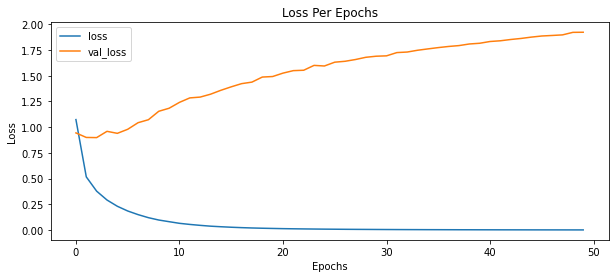

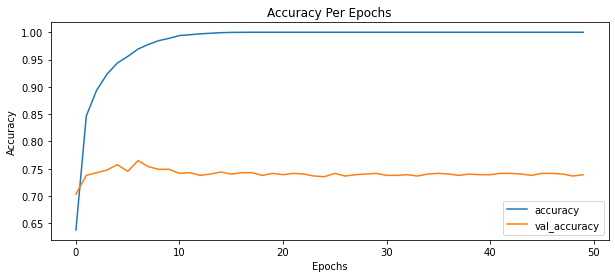

In [12]:
def plot_learning_curves(training):
    train_hist = pd.DataFrame(training.history)

    plt.figure(figsize=(10,4))
    plt.plot(train_hist[['loss','val_loss']])
    plt.legend(['loss','val_loss'])
    plt.title('Loss Per Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(train_hist[['accuracy','val_accuracy']])
    plt.legend(['accuracy','val_accuracy'])
    plt.title('Accuracy Per Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
plot_learning_curves(training)

What can we see by lookin at the learning curves? The bad thing is taht during the training the validation loss is increasing. The good thing is that the validation score is quite hight. Now, let's get its score on test set.

In [13]:
test_loss, test_accuracy = model1.evaluate(test_X, test_Y)
print('Accuracy on test dataset:', test_accuracy)

27/27 [==============================] - 0s 1ms/step - loss: 1.5751 - accuracy: 0.7611
Accuracy on test dataset: 0.76105135679245


The accuracy score on test set is also quite good. But we already now that our data organized in folds is diversified and when testing model od different folds the score can vary up to 20%. Those good scores can be a matter of luck. </br>
Just to be clear let's evaluate our model with corss validation. We will use 9 folds (form 1 to 9) for this purpouse. We will make 3 splits (we could make 9 splits but this wolud take much longer to get results, the function below can be easly modificated for 9 split if needed).

In [14]:
def my_eval_9folds(clf, compile_params, initial_weights, fit_params):
    global df, X_all, Y
    # let's filter our df
    train_df = df.loc[df['fold']<10]
    temp_X = X_all.loc[df['fold']<10]
    
    # generate list of tuples with train and validate indexes
    cv_groups = []
    for i in range(1, 10, 3): # comment this line to get 9 splits
#     for i in range(1, 10): # uncomment this line to get 9 splits
        a , b, c = i, i+1, i+2 # comment this line to get 9 splits
        temp_train_X = temp_X.loc[(train_df['fold']!=a) & (train_df['fold']!=b) & (train_df['fold']!=c)].copy() # comment this line to get 9 splits
        temp_valid_X = temp_X.loc[(train_df['fold']==a) | (train_df['fold']==b) | (train_df['fold']==c)].copy() # comment this line to get 9 splits
#         temp_train_X = temp_X.loc[train_df['fold']!=i].copy() # uncomment this line to get 9 splits
#         temp_valid_X = temp_X.loc[train_df['fold']==i].copy() # uncomment this line to get 9 splits
        cv_groups.append((temp_train_X.index, temp_valid_X.index))
    
    scores = []
    # copy fit params to make changes for CV
    f_params = fit_params.copy()
    f_params['validation_data'] = None # train without predefined validating data
    f_params['validation_split'] = 0.1 # exclude validatin data fron training set - it is necessary when early stopping
    f_params['verbose'] = 0 # we do not want output during training
    
    for train_indexes, valid_indexes in cv_groups:
        # prepare features and labels for training
        train_X = temp_X.loc[train_indexes]
        scaler = StandardScaler() # we need the features to be scaled to use as input for NN
        train_X = scaler.fit_transform(train_X)
        train_Y = Y.loc[train_indexes]
        train_Y = pd.get_dummies(train_Y) # prepare labels to get 0's and 1's as output for every class
        # prepare features amd labels for validation
        valid_X = temp_X.loc[valid_indexes]
        valid_X = scaler.transform(valid_X)
        valid_Y = Y.loc[valid_indexes]
        valid_Y = pd.get_dummies(valid_Y)
        
        # make a copy and compile a model
        tf.random.set_seed(42)
        model = tf.keras.models.clone_model(clf)
        model.compile(**compile_params)
        model.build(train_X.shape)
        model.set_weights(initial_weights)
        
        # update fit_params
        f_params['x'] = train_X
        f_params['y'] = train_Y
        model.fit(**f_params)
        scores.append(model.evaluate(valid_X, valid_Y, verbose=0))
    
    valid_loss, valid_scores = zip(*scores)
    
    return valid_scores

To use this function we need to keep parameters of models compile() and fit() functions in dictionaries. We also want to keep models weights after they are initialized. Let's rewrite the definition of model1 using dictionaries for parameters.

In [15]:
# set random seed
tf.random.set_seed(42)

# build a model
model1_layers = [
    tf.keras.layers.Dense(380, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model1 = tf.keras.Sequential(model1_layers)

# compile the model
model1_compile_params = dict(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model1.compile(**model1_compile_params)

# model have to be build to initialize weigths in the layers
model1.build(train_X.shape)
model1_initial_weights = model1.get_weights()

# train the model
model1_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=50, verbose=0)

model1_training = model1.fit(**model1_fit_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Now we can call our cross validation function.

In [16]:
scores = my_eval_9folds(model1, model1_compile_params, model1_initial_weights, model1_fit_params)
print(scores)
print('Average score: ',np.mean(scores))

(0.6221146583557129, 0.6693342924118042, 0.6829268336296082)
Average score:  0.6581252614657084


Ok. Now let's build few other models with different numbers of layers and perceptrons in layers.

In [17]:
# set random seed
tf.random.set_seed(42)

# build a model
model2_layers = [
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model2 = tf.keras.Sequential(model2_layers)

# compile the model
model2_compile_params = dict(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model2.compile(**model2_compile_params)


model2.build(train_X.shape)
model2_initial_weights = model2.get_weights()


# train the model
model2_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=50, verbose=0)

model2_training = model2.fit(**model2_fit_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



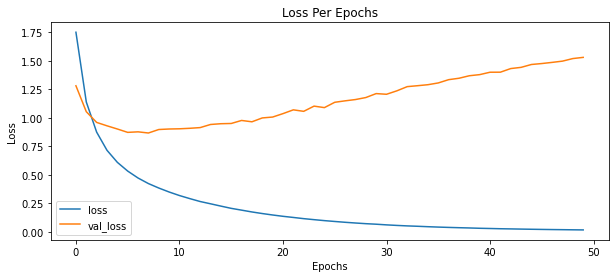

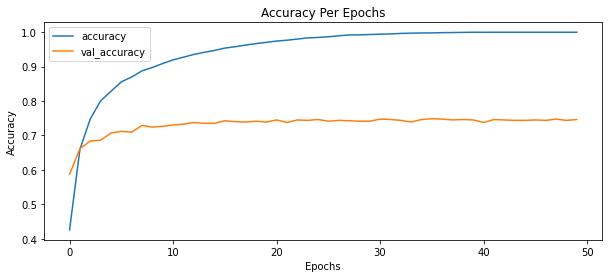

In [18]:
plot_learning_curves(model2_training)

In [19]:
scores = my_eval_9folds(model2, model2_compile_params, model2_initial_weights, model2_fit_params)
print(scores)
print('Average score: ',np.mean(scores))

(0.6243484616279602, 0.6675154566764832, 0.6914634108543396)
Average score:  0.6611091097195944


We can see that decreasing learnig rate helped but loss for validating set is still increasing during training. We will try 2 things in 2 next models: early stopping and regularization.

In [20]:
# set random seed
tf.random.set_seed(42)

# build a model
model3_layers = [
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model3 = tf.keras.Sequential(model3_layers)

# compile the model
model3_compile_params = dict(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model3.compile(**model3_compile_params)


model3.build(train_X.shape)
model3_initial_weights = model3.get_weights()


# train the model
model3_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # callback for early stopping

model3_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=50, verbose=0,
                        callbacks=[model3_callback])

model3_training = model3.fit(**model3_fit_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



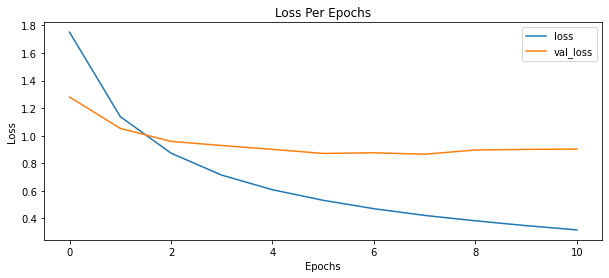

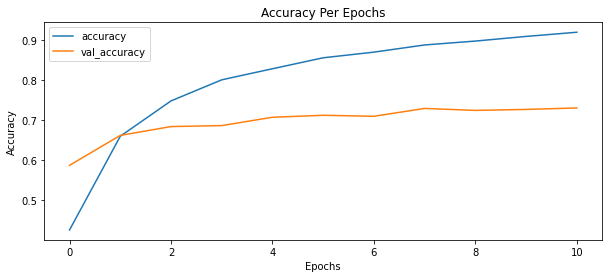

In [21]:
plot_learning_curves(model3_training)

In [22]:
scores = my_eval_9folds(model3, model3_compile_params, model3_initial_weights, model3_fit_params)
print(scores)
print('Average score: ',np.mean(scores))

(0.5982874035835266, 0.6576936841011047, 0.6833333373069763)
Average score:  0.6464381416638693


The accuracy from cross validation is worse. Let's check what can we achive with regularization.

In [23]:
# set random seed
tf.random.set_seed(42)

# build a model
from tensorflow.keras import regularizers
alfa = 0.005

model4_layers = [
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model4 = tf.keras.Sequential(model4_layers)

# compile the model
model4_compile_params = dict(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model4.compile(**model4_compile_params)


model4.build(train_X.shape)
model4_initial_weights = model4.get_weights()


# train the model
model4_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=50, verbose=0)

model4_training = model4.fit(**model4_fit_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



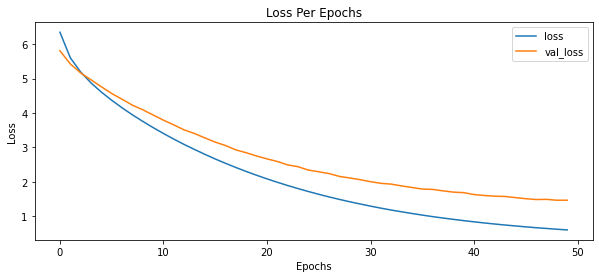

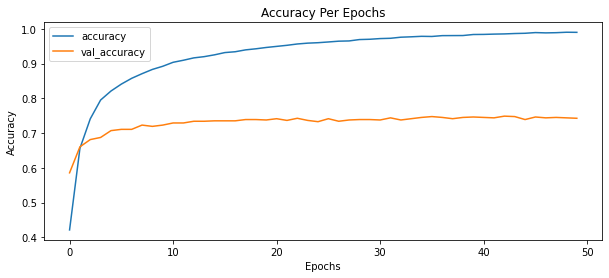

In [24]:
plot_learning_curves(model4_training)

In [25]:
scores = my_eval_9folds(model4, model4_compile_params, model4_initial_weights, model4_fit_params)
print(scores)
print('Average score: ',np.mean(scores))

(0.6273269057273865, 0.6736994981765747, 0.6878048777580261)
Average score:  0.6629437605539957


Regilatization improved our model. The score is better and the curve looks much better. Let's try models with more layers.

In [26]:
# set random seed
tf.random.set_seed(42)

# build a model
from tensorflow.keras import regularizers
alfa = 0.005

model5_layers = [
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model5 = tf.keras.Sequential(model5_layers)

# compile the model
model5_compile_params = dict(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model5.compile(**model5_compile_params)


model5.build(train_X.shape)
model5_initial_weights = model5.get_weights()


# train the model
model5_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=50, verbose=0)

model5_training = model5.fit(**model5_fit_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



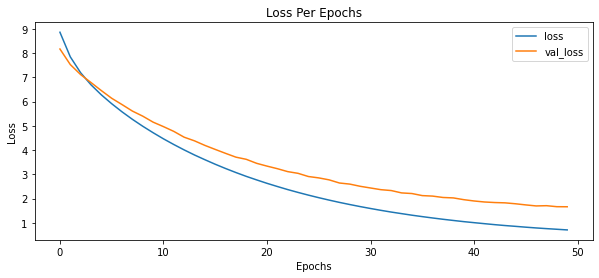

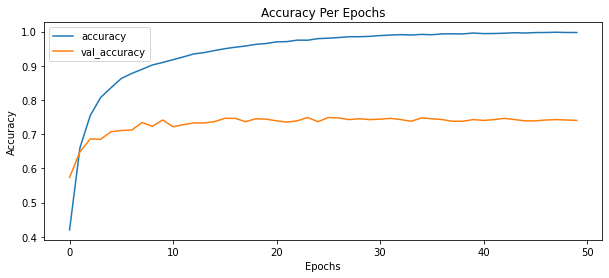

In [27]:
plot_learning_curves(model5_training)

In [28]:
scores = my_eval_9folds(model5, model5_compile_params, model5_initial_weights, model5_fit_params)
print(scores)
print('Average score: ',np.mean(scores))

(0.6344006061553955, 0.6638777852058411, 0.6902438998222351)
Average score:  0.6628407637278239


In [29]:
# set random seed
tf.random.set_seed(42)

# build a model
from tensorflow.keras import regularizers
alfa = 0.005

model6_layers = [
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model6 = tf.keras.Sequential(model6_layers)

# compile the model
model6_compile_params = dict(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model6.compile(**model6_compile_params)


model6.build(train_X.shape)
model6_initial_weights = model6.get_weights()


# train the model
model6_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=50, verbose=0)

model6_training = model6.fit(**model6_fit_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



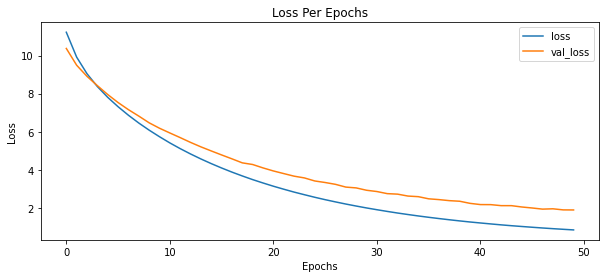

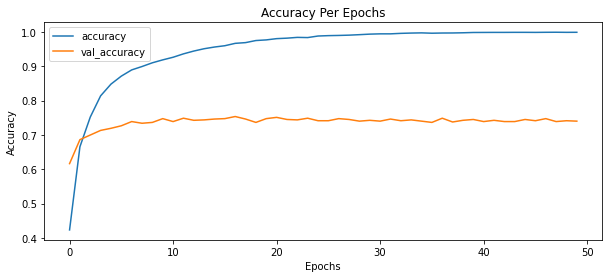

In [30]:
plot_learning_curves(model6_training)

In [31]:
scores = my_eval_9folds(model6, model6_compile_params, model6_initial_weights, model6_fit_params)
print(scores)
print('Average score: ',np.mean(scores))

(0.6314221620559692, 0.6576936841011047, 0.6837398409843445)
Average score:  0.6576185623804728


In [32]:
# set random seed
tf.random.set_seed(42)

# build a model
from tensorflow.keras import regularizers
alfa = 0.005

model7_layers = [
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model7 = tf.keras.Sequential(model7_layers)

# compile the model
model7_compile_params = dict(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model7.compile(**model7_compile_params)


model7.build(train_X.shape)
model7_initial_weights = model7.get_weights()


# train the model
model7_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=50, verbose=0)

model7_training = model7.fit(**model7_fit_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



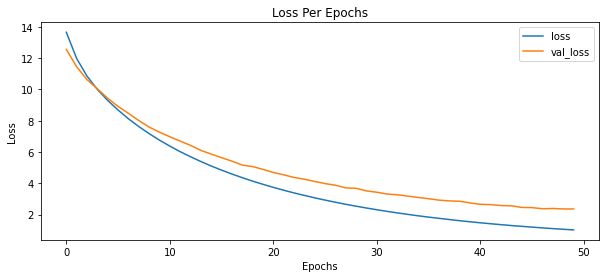

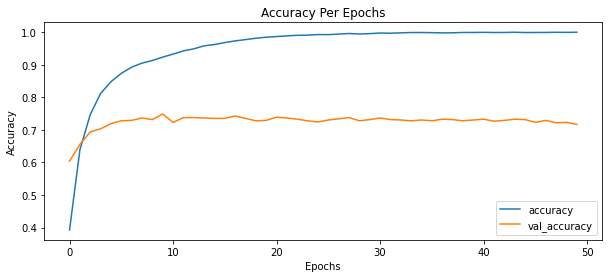

In [33]:
plot_learning_curves(model7_training)

In [34]:
scores = my_eval_9folds(model7, model7_compile_params, model7_initial_weights, model7_fit_params)
print(scores)
print('Average score: ',np.mean(scores))

(0.6247207522392273, 0.6402328014373779, 0.675203263759613)
Average score:  0.6467189391454061


model5 with 3 hidden layer got best score. Let's try 3-layer models with other number of perceptrons in layer.

In [35]:
# set random seed
tf.random.set_seed(42)

# build a model
from tensorflow.keras import regularizers
alfa = 0.005

model8_layers = [
    tf.keras.layers.Dense(750, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(750, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(750, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model8 = tf.keras.Sequential(model8_layers)

# compile the model
model8_compile_params = dict(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model8.compile(**model8_compile_params)


model8.build(train_X.shape)
model8_initial_weights = model8.get_weights()


# train the model
model8_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=50, verbose=0)

model8_training = model8.fit(**model8_fit_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



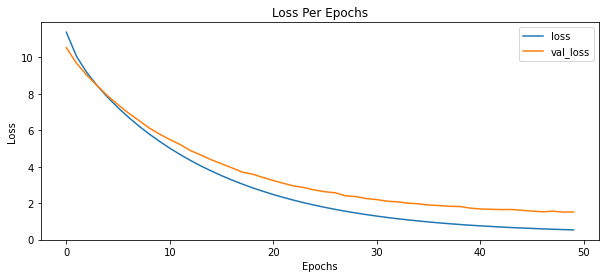

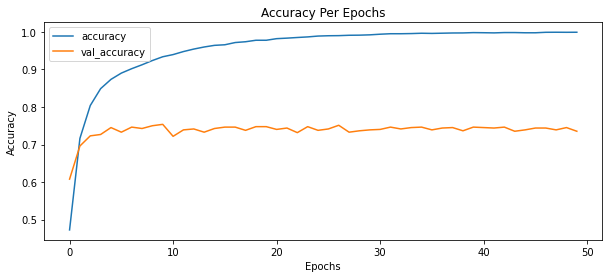

In [36]:
plot_learning_curves(model8_training)

In [37]:
scores = my_eval_9folds(model8, model8_compile_params, model8_initial_weights, model8_fit_params)
print(scores)
print('Average score: ',np.mean(scores))

(0.6288160681724548, 0.6616951823234558, 0.6934959292411804)
Average score:  0.6613357265790304


It is better then model5. Let's try another one.

In [38]:
# set random seed
tf.random.set_seed(42)

# build a model
from tensorflow.keras import regularizers
alfa = 0.005

model9_layers = [
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model9 = tf.keras.Sequential(model9_layers)

# compile the model
model9_compile_params = dict(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model9.compile(**model9_compile_params)


model9.build(train_X.shape)
model9_initial_weights = model9.get_weights()


# train the model
model9_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=50, verbose=0)

model9_training = model9.fit(**model9_fit_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



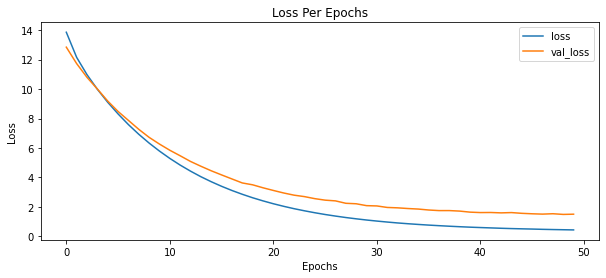

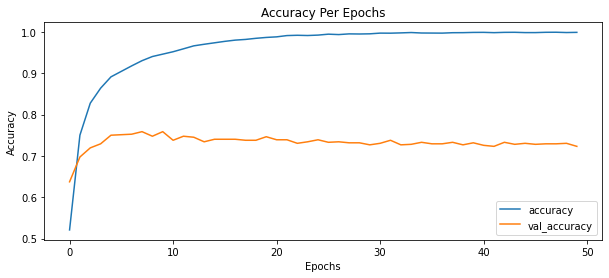

In [39]:
plot_learning_curves(model9_training)

In [40]:
scores = my_eval_9folds(model9, model9_compile_params, model9_initial_weights, model9_fit_params)
print(scores)
print('Average score: ',np.mean(scores))

(0.6262099742889404, 0.6595125794410706, 0.687398374080658)
Average score:  0.6577069759368896


Model with 500 perceprtons in layer is still the best. Let's try another one.

In [41]:
# set random seed
tf.random.set_seed(42)

# build a model
from tensorflow.keras import regularizers
alfa = 0.005

model10_layers = [
    tf.keras.layers.Dense(600, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(600, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(600, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model10 = tf.keras.Sequential(model10_layers)

# compile the model
model10_compile_params = dict(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model10.compile(**model10_compile_params)


model10.build(train_X.shape)
model10_initial_weights = model10.get_weights()


# train the model
model10_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=50, verbose=0)

model10_training = model10.fit(**model10_fit_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



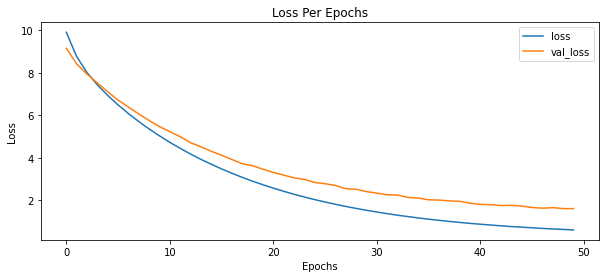

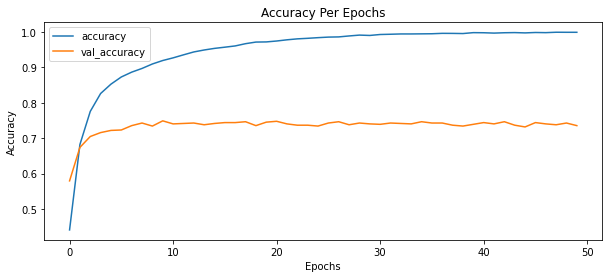

In [42]:
plot_learning_curves(model10_training)

In [43]:
scores = my_eval_9folds(model10, model10_compile_params, model10_initial_weights, model10_fit_params)
print(scores)
print('Average score: ',np.mean(scores))

(0.6250931024551392, 0.6533284783363342, 0.6902438998222351)
Average score:  0.6562218268712362


There is no direct relation between number of perceptrons in layer and models accuracy. Let's try adding a dropout layers.

In [44]:
# set random seed
tf.random.set_seed(42)

# build a model
from tensorflow.keras import regularizers
alfa = 0.005

model11_layers = [
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model11 = tf.keras.Sequential(model11_layers)

# compile the model
model11_compile_params = dict(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model11.compile(**model11_compile_params)


model11.build(train_X.shape)
model11_initial_weights = model11.get_weights()


# train the model
model11_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=50, verbose=0)

model11_training = model11.fit(**model11_fit_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



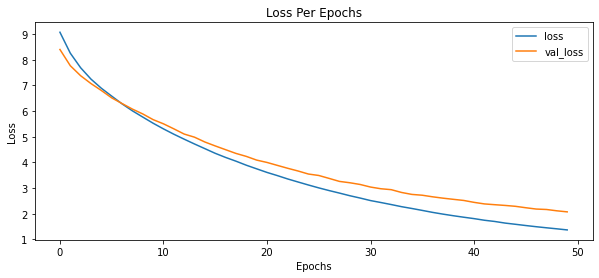

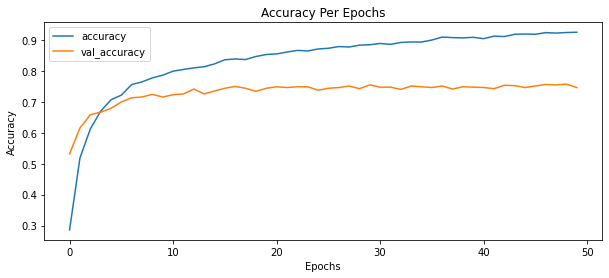

In [45]:
plot_learning_curves(model11_training)

In [46]:
scores = my_eval_9folds(model11, model11_compile_params, model11_initial_weights, model11_fit_params)
print(scores)
print('Average score: ',np.mean(scores))

(0.6396127939224243, 0.667151689529419, 0.6918699145317078)
Average score:  0.666211465994517


We can try other values for regularization, for learning rate, for dropout. We can also try adding new layers and changing number of perceptrons in individual layers to find the best model for our task.

In [47]:
# set random seed
tf.random.set_seed(42)

# build a model
from tensorflow.keras import regularizers
alfa = 0.003

model12_layers = [
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model12 = tf.keras.Sequential(model12_layers)

# compile the model
model12_compile_params = dict(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model12.compile(**model12_compile_params)


model12.build(train_X.shape)
model12_initial_weights = model12.get_weights()


# train the model
model12_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=100, verbose=0)

model12_training = model12.fit(**model12_fit_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



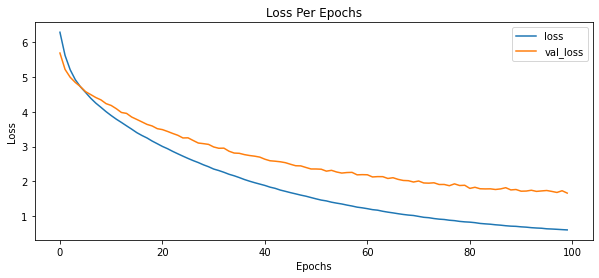

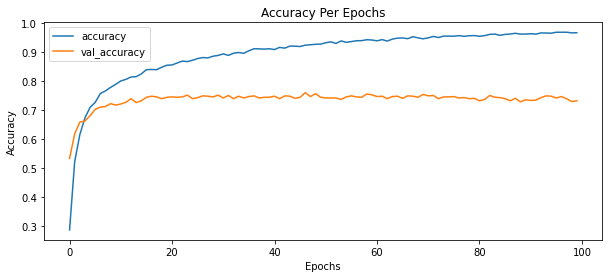

In [48]:
plot_learning_curves(model12_training)

In [49]:
scores = my_eval_9folds(model12, model12_compile_params, model12_initial_weights, model12_fit_params)
print(scores)
print('Average score: ',np.mean(scores))

(0.6396127939224243, 0.670789361000061, 0.6922764182090759)
Average score:  0.6675595243771871


Let's transform our features with QuantileTransformer instead of using StandardScaler and check what will happen.

In [50]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal', random_state=44)
train_X_qt = pd.DataFrame(qt.fit_transform(train_X), columns=train_X.columns,  index=train_X.index)
valid_X_qt = pd.DataFrame(qt.transform(valid_X), columns=valid_X.columns,  index=valid_X.index)

In [51]:
# set random seed
tf.random.set_seed(42)

# build a model
from tensorflow.keras import regularizers
alfa = 0.003

model13_layers = [
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model13 = tf.keras.Sequential(model13_layers)

# compile the model
model13_compile_params = dict(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model13.compile(**model13_compile_params)


model13.build(train_X.shape)
model13_initial_weights = model13.get_weights()


# train the model
model13_fit_params = dict(x=train_X_qt, y=train_Y, batch_size=200, validation_data=(valid_X_qt, valid_Y), epochs=100, verbose=0)

model13_training = model13.fit(**model13_fit_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



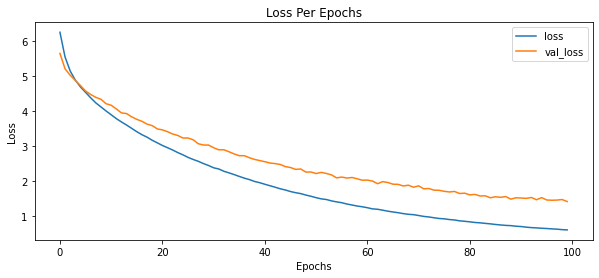

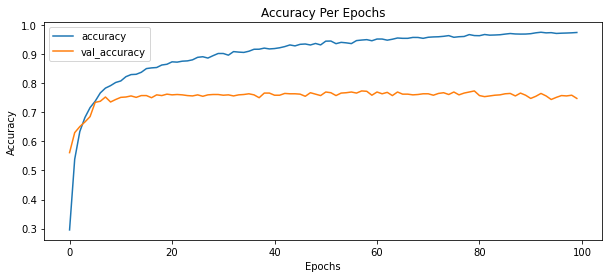

In [52]:
plot_learning_curves(model13_training)

In [53]:
def my_eval_9foldsV2(clf, features_pipe, compile_params, initial_weights, fit_params):
    global df, X_all, Y
    # let's filter our df
    train_df = df.loc[df['fold']<10]
    temp_X = X_all.loc[df['fold']<10]
    
    # generate list of tuples with train and validate indexes
    cv_groups = []
    for i in range(1, 10, 3):
#     for i in range(1, 10):
        a , b, c = i, i+1, i+2
        temp_train_X = temp_X.loc[(train_df['fold']!=a) & (train_df['fold']!=b) & (train_df['fold']!=c)].copy()
        temp_valid_X = temp_X.loc[(train_df['fold']==a) | (train_df['fold']==b) | (train_df['fold']==c)].copy()
#         temp_train_X = temp_X.loc[train_df['fold']!=i].copy()
#         temp_valid_X = temp_X.loc[train_df['fold']==i].copy()
        cv_groups.append((temp_train_X.index, temp_valid_X.index))
    
    scores = []
    # copy fit params to make changes for CV
    f_params = fit_params.copy()
    f_params['validation_data'] = None # train without predefined validating data
    f_params['validation_split'] = 0.1 # exclude validatin data fron training set - it is necessary when early stopping
    f_params['verbose'] = 0 # we do not want output during training
    
    for train_indexes, valid_indexes in cv_groups:
        # prepare features and labels for training
        train_X = temp_X.loc[train_indexes]
        train_X = features_pipe.fit_transform(train_X)
        train_Y = Y.loc[train_indexes]
        train_Y = pd.get_dummies(train_Y)
        # prepare features amd labels for validation
        valid_X = temp_X.loc[valid_indexes]
        valid_X = features_pipe.transform(valid_X)
        valid_Y = Y.loc[valid_indexes]
        valid_Y = pd.get_dummies(valid_Y)
        
        # make a copy and compile a model
        tf.random.set_seed(42)
        model = tf.keras.models.clone_model(clf)
        model.compile(**compile_params)
        model.build(train_X.shape)
        model.set_weights(initial_weights)
        
        # update fit_params
        f_params['x'] = train_X
        f_params['y'] = train_Y
        model.fit(**f_params)
        scores.append(model.evaluate(valid_X, valid_Y, verbose=0))
    
    valid_loss, valid_scores = zip(*scores)
    
    return valid_scores

In [54]:
scores = my_eval_9foldsV2(model13, qt, model13_compile_params, model13_initial_weights, model13_fit_params)
print(scores)
print('Average score: ',np.mean(scores))

(0.652271032333374, 0.6984357833862305, 0.7044715285301208)
Average score:  0.6850594480832418


The features transformations can be optimized to get better results just like it was made in previous parts. So this is how we can work with Feed Forward Networks using Tensorflow library. Now I'd like to step into next point which is Convolutional Neural Networks.

Let's start with extracting new features - Mel Spectrograms. We will retrive features in shape of image and we could apply CNN's to it like it is being done in standard image recognition/classification tasks.

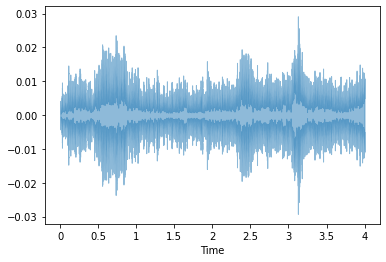

In [78]:
#getting the file name from dataset metadata
file_path = 'fold' + str(df.iloc[1]['fold']) + '/' + df.iloc[1]['slice_file_name']

#geting audio as samples list, the audio is converted to mono and resampled to 44100 if needed
y, sr = lb.load(file_path, mono=True, sr=44100)

librosa.display.waveshow(y, sr=sr, alpha=0.5)

In [79]:
mel_bands = 128
frame_size = 1024
hop_size = 512

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=150, n_fft=2048, hop_length=1024, fmax=8000)
    

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

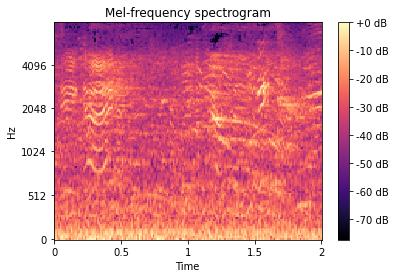

In [80]:
fig, ax = plt.subplots()

S_dB = librosa.power_to_db(S, ref=np.max)

img = librosa.display.specshow(S_dB, x_axis='time',

                         y_axis='mel', sr=sr,

                         fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set(title='Mel-frequency spectrogram')

In [81]:
def my_get_feature(file_path):
    y, sr = lb.load(file_path, mono=True, sr=44100)
    y = np.concatenate((y, np.zeros(4*sr)))
    y = y[0:4*sr]
    S = lb.feature.melspectrogram(y=y, sr=sr, n_mels=150, n_fft=2048, hop_length=1024, fmax=8000)
    data = lb.power_to_db(S, ref=np.max)
    return data

In [82]:
def get_features(data_frame):
    
    features = []
    classes = []
    
    for i in range(len(data_frame)):
        file_path = 'fold' + str(data_frame.iloc[i]['fold']) + '/' + data_frame.iloc[i]['slice_file_name']

        features.append(my_get_feature(file_path))
            
        classes.append(data_frame.iloc[i]['classID'])
        
    X = np.array(features)
    y = np.array(classes)
    Y = pd.get_dummies(y)
    return X, Y

In [96]:
X_ms = {}
Y_ms = {}
for i in range(1,11):
    print(i, end=',') # just to monitor progress
    X_ms[i], Y_ms[i] = get_features(df.loc[df['fold']==i])

1,2,3,4,5,6,7,8,9,10,

In [98]:
X_ms.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [123]:
lst = list(X_ms.keys())
ind = lst.pop(9)
ind = lst.pop(8)
valid_X = X_ms[ind]
valid_Y = Y_ms[ind]
train_X_lst = [X_ms[i] for i in lst]
train_X = np.vstack(tuple(train_X_lst))
train_Y_lst = [Y_ms[i] for i in lst]
train_Y = np.vstack(tuple(train_Y_lst))

In [124]:
valid_X.shape, valid_Y.shape

((816, 150, 173), (816, 10))

In [125]:
test_X, test_Y = X_ms[10], Y_ms[10]
test_X.shape, test_Y.shape

((837, 150, 173), (837, 10))

In [126]:
train_X.shape, train_Y.shape

((7079, 150, 173), (7079, 10))

In [127]:
# train_X = train_X.values
train_X = train_X.reshape(train_X.shape[0], 150, 173, 1)
# valid_X = valid_X.values
valid_X = valid_X.reshape(valid_X.shape[0], 150, 173, 1)
# test_X = test_X.values
test_X = test_X.reshape(test_X.shape[0], 150, 173, 1)

Let's build our 1st CNN model

In [134]:
# set random seed
tf.random.set_seed(42)

# build a model
from tensorflow.keras import regularizers
alfa = 0.01
dropout = 0.2
model14_layers = [
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation=tf.nn.relu,
                           input_shape=(150, 173, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model14 = tf.keras.Sequential(model14_layers)

# compile the model
model14_compile_params = dict(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model14.compile(**model14_compile_params)


model14.build(train_X.shape)
model14_initial_weights = model14.get_weights()


# train the model
model14_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=20, verbose=1)

model14_training = model14.fit(**model14_fit_params)

Epoch 1/20
36/36 [==============================] - 149s 4s/step - loss: 68.4294 - accuracy: 0.1116 - val_loss: 20.1853 - val_accuracy: 0.1225
Epoch 2/20
36/36 [==============================] - 140s 4s/step - loss: 18.2260 - accuracy: 0.2762 - val_loss: 16.3507 - val_accuracy: 0.3946
Epoch 3/20
36/36 [==============================] - 142s 4s/step - loss: 15.0136 - accuracy: 0.5054 - val_loss: 13.7870 - val_accuracy: 0.5404
Epoch 4/20
36/36 [==============================] - 133s 4s/step - loss: 12.9453 - accuracy: 0.6234 - val_loss: 12.3704 - val_accuracy: 0.5858
Epoch 5/20
36/36 [==============================] - 134s 4s/step - loss: 11.4326 - accuracy: 0.6896 - val_loss: 11.0927 - val_accuracy: 0.6029
Epoch 6/20
36/36 [==============================] - 130s 4s/step - loss: 10.2138 - accuracy: 0.7402 - val_loss: 10.2507 - val_accuracy: 0.6091
Epoch 7/20
36/36 [==============================] - 148s 4s/step - loss: 9.2803 - accuracy: 0.7758 - val_loss: 9.4223 - val_accuracy: 0.6336
E

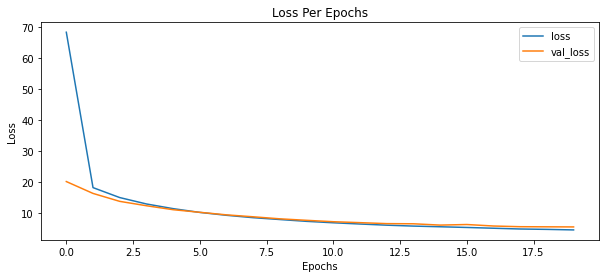

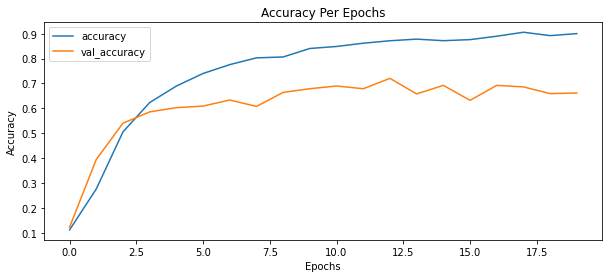

In [135]:
plot_learning_curves(model14_training)

In [136]:
test_loss, test_accuracy = model14.evaluate(test_X, test_Y)
print('Accuracy on test dataset:', test_accuracy)

27/27 [==============================] - 5s 197ms/step - loss: 5.5036 - accuracy: 0.5854
Accuracy on test dataset: 0.5854241251945496


We need new version of cross validation since our features and labels are numpy arrays.

Let's try scaled features.

In [151]:
lst = list(X_ms.keys())
ind = lst.pop(9)
ind = lst.pop(8)
valid_X = X_ms[ind]
valid_Y = Y_ms[ind]
train_X_lst = [X_ms[i] for i in lst]
train_X = np.vstack(tuple(train_X_lst))
train_Y_lst = [Y_ms[i] for i in lst]
train_Y = np.vstack(tuple(train_Y_lst))

test_X, test_Y = X_ms[10], Y_ms[10]

train_X = train_X.reshape(train_X.shape[0], -1)
valid_X = valid_X.reshape(valid_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal', random_state=44)
train_X = qt.fit_transform(train_X)
valid_X = qt.transform(valid_X)
test_X = qt.transform(test_X)

# scaler = StandardScaler()
# train_X = scaler.fit_transform(train_X)
# valid_X = scaler.transform(valid_X)
# test_X = scaler.transform(test_X)

train_X = train_X.reshape(train_X.shape[0], 150, 173, 1)
valid_X = valid_X.reshape(valid_X.shape[0], 150, 173, 1)
test_X = test_X.reshape(test_X.shape[0], 150, 173, 1)

In [148]:
# set random seed
tf.random.set_seed(42)

# build a model
from tensorflow.keras import regularizers
alfa = 0.01
dropout = 0.2
model14_layers = [
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation=tf.nn.relu,
                           input_shape=(150, 173, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(alfa)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
]

model14 = tf.keras.Sequential(model14_layers)

# compile the model
model14_compile_params = dict(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model14.compile(**model14_compile_params)


model14.build(train_X.shape)
model14_initial_weights = model14.get_weights()


# train the model
model14_fit_params = dict(x=train_X, y=train_Y, batch_size=200, validation_data=(valid_X, valid_Y), epochs=20, verbose=1)

model14_training = model14.fit(**model14_fit_params)

Epoch 1/20
36/36 [==============================] - 132s 4s/step - loss: 15.3118 - accuracy: 0.2050 - val_loss: 9.2740 - val_accuracy: 0.2341
Epoch 2/20
36/36 [==============================] - 133s 4s/step - loss: 7.2395 - accuracy: 0.4276 - val_loss: 5.9083 - val_accuracy: 0.4706
Epoch 3/20
36/36 [==============================] - 131s 4s/step - loss: 5.2182 - accuracy: 0.5427 - val_loss: 4.6722 - val_accuracy: 0.5257
Epoch 4/20
36/36 [==============================] - 132s 4s/step - loss: 4.2612 - accuracy: 0.6269 - val_loss: 4.0304 - val_accuracy: 0.6115
Epoch 5/20
36/36 [==============================] - 131s 4s/step - loss: 3.6797 - accuracy: 0.6820 - val_loss: 3.6513 - val_accuracy: 0.6164
Epoch 6/20
36/36 [==============================] - 132s 4s/step - loss: 3.2133 - accuracy: 0.7189 - val_loss: 3.3089 - val_accuracy: 0.6434
Epoch 7/20
36/36 [==============================] - 131s 4s/step - loss: 2.8703 - accuracy: 0.7486 - val_loss: 2.9953 - val_accuracy: 0.6225
Epoch 8/20
3

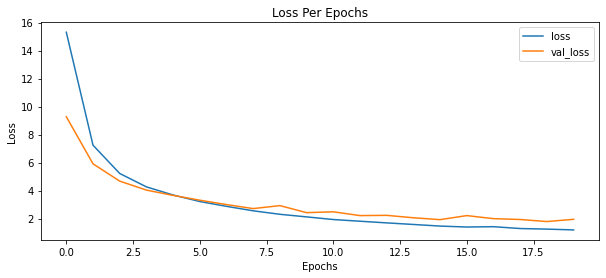

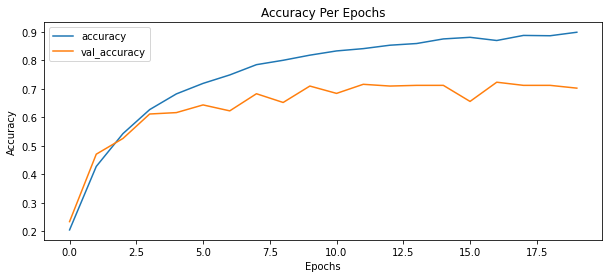

In [149]:
plot_learning_curves(model14_training)

In [152]:
test_loss, test_accuracy = model14.evaluate(test_X, test_Y)
print('Accuracy on test dataset:', test_accuracy)

27/27 [==============================] - 5s 188ms/step - loss: 1.9750 - accuracy: 0.6547
Accuracy on test dataset: 0.6547192335128784


to be continued..